In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 3478k    0     0  3029k      0  0:04:25  0:00:01  0:04:24 3043k
  1  786M    1 12.4M    0     0  5889k      0  0:02:16  0:00:02  0:02:14 5904k
  2  786M    2 22.5M    0     0  7267k      0  0:01:50  0:00:03  0:01:47 7281k
  4  786M    4 33.3M    0     0  8243k      0  0:01:37  0:00:04  0:01:33 8254k
  5  786M    5 44.3M    0     0  8808k      0  0:01:31  0:00:05  0:01:26 9095k
  7  786M    7 55.1M    0     0  9177k      0  0:01:27  0:00:06  0:01:21 10.3M
  8  786M    8 65.3M    0     0  9363k      0  0:01:26  0:00:07  0:01:19 10.6M
  9  786M    9 76.6M    0     0  9631k      0  0:01:23  0:00:08  0:01:15 10.8M
 11  786M   11 87.1M    0     0  9719k      0  0:01

In [19]:
import zipfile
with zipfile.ZipFile('kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [20]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [21]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


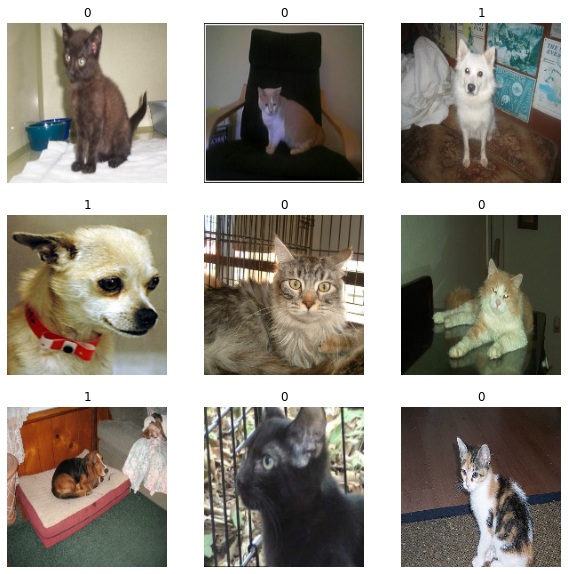

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

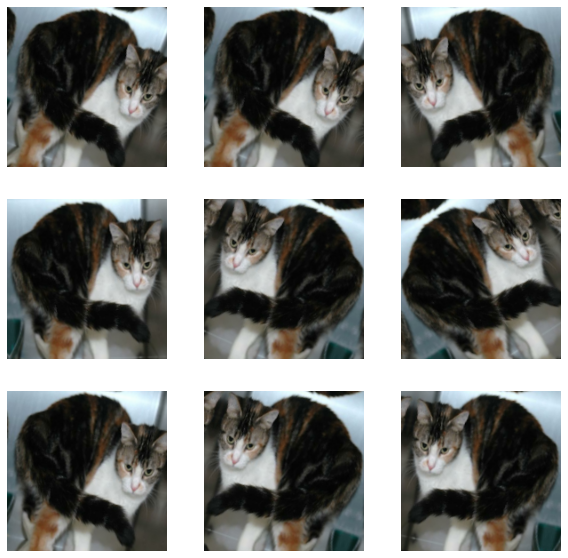

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [26]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [29]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
model.summary()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[2][0]']             
                     

In [32]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
epochs = 50

tf.debugging.set_log_device_placement(True)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
with tf.device('/GPU:0'):
    model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
586/586 [==============================] - 761s 1s/step - loss: 0.3938 - accuracy: 0.8254 - val_loss: 0.3593 - val_accuracy: 0.8437
Epoch 2/50
586/586 [==============================] - 754s 1s/step - loss: 0.3273 - accuracy: 0.8565 - val_loss: 0.4118 - val_accuracy: 0.8375
Epoch 3/50
586/586 [==============================] - 725s 1s/step - loss: 0.2758 - accuracy: 0.8807 - val_loss: 0.3204 - val_accuracy: 0.8621
Epoch 4/50
586/586 [==============================] - 729s 1s/step - loss: 0.2345 - accuracy: 0.9034 - val_loss: 0.2661 - val_accuracy: 0.8958
Epoch 5/50
586/586 [==============================] - 722s 1s/step - loss: 0.2130 - accuracy: 0.9109 - val_loss: 0.4740 - val_accuracy: 0.8239
Epoch 6/50
586/586 [==============================] - 712s 1s/step - loss: 0.1957 - accuracy: 0.9176 - val_loss: 0.2177 - val_accuracy: 0.9073
Epoch 7/50
586/586 [==============================] - 724s 1s/step - loss: 0.1803 - accuracy: 0.9276 - val_loss: 0.1994 - val_accuracy: 0.9298

In [38]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 68.05 percent cat and 31.95 percent dog.
